In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from cuml.ensemble import RandomForestRegressor as cuRF
import xgboost as xgb
from scripts.function_utils import correct_wind_direction, test_leave_house_out, total_averaged_metrics, add_energy_variation

#### Output file

In [34]:
sourceFile = open("../../gpu_logs/loureiro_selected_hyp.txt", 'w')

### Load the data

In [34]:
weather = pd.read_pickle("../../data/station_aveiro_all.pkl")
weather.drop(["Temp_Max", "Temp_Min", "Intensidade_Vento_Max", "Rumo_Vento_Max"], axis=1, inplace=True)
weather = weather.iloc[55824:]
weather.reset_index(drop=True, inplace=True)
weather

,Time,Temp_Med,Rumo_Vento_Med,Intensidade_Vento_Med,Precip,Rad_Total
0,2022-05-05 12:00:00,22.70,305.0,3.80,0.0,526.00
1,2022-05-05 12:15:00,22.55,311.5,4.05,0.0,523.35
2,2022-05-05 12:30:00,22.10,311.0,4.10,0.0,520.00
3,2022-05-05 12:45:00,21.95,300.0,4.45,0.0,514.40
4,2022-05-05 13:00:00,22.20,314.0,4.00,0.0,507.00
...,...,...,...,...,...,...
31723,2023-03-31 22:45:00,-990.00,-990.0,-990.00,-990.0,-990.00
31724,2023-03-31 23:00:00,-990.00,-990.0,-990.00,-990.0,-990.00
31725,2023-03-31 23:15:00,-990.00,-990.0,-990.00,-990.0,-990.00
31726,2023-03-31 23:30:00,-990.00,-990.0,-990.00,-990.0,-990.00


In [35]:
merged = pd.read_csv("../../data/loureiro.csv")
#merged = correct_wind_direction(merged).drop(["Temp_Max","Temp_Min","Rumo_Vento_Med", "Rumo_Vento_Max", "Intensidade_Vento_Max"], axis=1)
#merged.Time = pd.to_datetime(merged.Time)
merged

,Time,Energy_1,Energy_2,Energy_3,Energy_4,Energy_5,Energy_6,Energy_7,Energy_8,Energy_9,...,Energy_163,Energy_164,Energy_165,Energy_166,Energy_167,Energy_168,Energy_169,Energy_170,Energy_171,Energy_172
0,2022-05-05 12:00:00,0.068,NaN,0.034,0.038,0.000,NaN,NaN,NaN,NaN,...,NaN,0.004,0.0,NaN,NaN,NaN,0.395,NaN,NaN,0.008
1,2022-05-05 12:15:00,0.070,NaN,0.044,0.062,0.006,NaN,NaN,NaN,NaN,...,NaN,0.003,0.0,NaN,NaN,NaN,0.316,NaN,NaN,0.056
2,2022-05-05 12:30:00,0.122,NaN,0.037,0.045,0.000,NaN,NaN,NaN,NaN,...,NaN,0.004,0.0,NaN,NaN,NaN,0.264,NaN,NaN,0.033
3,2022-05-05 12:45:00,0.132,NaN,0.015,0.039,0.000,NaN,NaN,NaN,NaN,...,NaN,0.004,0.0,NaN,NaN,NaN,0.139,NaN,NaN,0.062
4,2022-05-05 13:00:00,0.125,NaN,0.015,0.040,0.032,NaN,NaN,NaN,NaN,...,NaN,0.004,0.0,NaN,NaN,NaN,0.138,NaN,NaN,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38014,2023-06-07 1:15:00,0.120,0.020,0.112,0.036,0.000,0.0,0.021,0.140,0.066,...,0.073,0.003,0.0,0.007,0.018,0.311,0.290,0.163,0.052,0.045
38015,2023-06-07 1:30:00,0.121,0.004,0.112,0.036,0.000,0.0,0.013,0.165,0.057,...,0.072,0.004,0.0,0.007,0.023,0.300,0.094,0.142,0.039,0.076
38016,2023-06-07 1:45:00,0.158,0.007,0.103,0.028,0.000,0.0,0.007,0.145,0.056,...,0.071,0.003,0.0,0.007,0.025,0.465,0.092,0.145,0.046,0.021
38017,2023-06-07 2:00:00,0.102,0.042,0.116,0.010,0.000,0.0,0.007,0.138,NaN,...,0.072,0.004,0.0,0.007,0.021,0.595,0.079,0.148,0.044,0.043


In [36]:
missing_values = merged.isna().sum()
selected_columns = merged.columns[np.where(missing_values <= 1000)]
df = merged[selected_columns]
print(df.isna().sum().sum())
df

10714


,Time,Energy_1,Energy_2,Energy_8,Energy_9,Energy_15,Energy_16,Energy_17,Energy_30,Energy_35,...,Energy_140,Energy_142,Energy_144,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_161,Energy_164
0,2022-05-05 12:00:00,0.068,NaN,NaN,NaN,0.164,0.072,0.055,NaN,0.080,...,0.0,0.084,0.0,0.068,0.060,0.042,NaN,0.069,NaN,0.004
1,2022-05-05 12:15:00,0.070,NaN,NaN,NaN,0.135,0.058,0.060,NaN,0.056,...,0.0,0.004,0.0,0.048,0.078,0.053,NaN,0.063,NaN,0.003
2,2022-05-05 12:30:00,0.122,NaN,NaN,NaN,0.121,0.011,0.096,NaN,0.052,...,0.0,0.004,0.0,0.062,0.061,0.057,NaN,0.049,NaN,0.004
3,2022-05-05 12:45:00,0.132,NaN,NaN,NaN,0.138,0.010,0.064,NaN,0.052,...,0.0,0.004,0.0,0.056,0.125,0.034,NaN,0.097,NaN,0.004
4,2022-05-05 13:00:00,0.125,NaN,NaN,NaN,0.104,0.011,0.072,NaN,0.053,...,0.0,0.004,0.0,0.034,0.070,0.038,NaN,0.075,NaN,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38014,2023-06-07 1:15:00,0.120,0.020,0.140,0.066,0.120,0.003,0.094,0.037,0.045,...,0.0,0.004,0.0,0.080,0.014,0.028,0.066,0.058,0.000,0.003
38015,2023-06-07 1:30:00,0.121,0.004,0.165,0.057,0.087,0.002,0.077,0.036,0.046,...,0.0,0.004,0.0,0.060,0.028,0.023,0.067,0.032,0.016,0.004
38016,2023-06-07 1:45:00,0.158,0.007,0.145,0.056,0.086,0.003,0.087,0.021,0.045,...,0.0,0.004,0.0,0.057,0.029,0.043,0.065,0.495,0.008,0.003
38017,2023-06-07 2:00:00,0.102,0.042,0.138,NaN,0.085,0.002,0.072,0.027,0.045,...,0.0,0.003,0.0,0.061,0.012,0.047,0.041,0.274,0.000,0.004


In [14]:
df.isna().sum()

Time             0
Energy_1        30
Energy_2       104
Energy_4      1339
Energy_9       141
Energy_10     1528
Energy_11     1067
Energy_15      129
Energy_16      194
Energy_17       13
Energy_28     1264
Energy_29     1172
Energy_30      149
Energy_35      120
Energy_48      141
Energy_50     1259
Energy_58      124
Energy_60      135
Energy_65      136
Energy_75     1534
Energy_78      493
Energy_86      304
Energy_90       23
Energy_91       12
Energy_94      204
Energy_95      124
Energy_96      117
Energy_103    1743
Energy_106    1156
Energy_108     194
Energy_110     703
Energy_117     111
Energy_118     117
Energy_123     977
Energy_125      17
Energy_126     137
Energy_127     123
Energy_129     126
Energy_132      10
Energy_135     194
Energy_136    1170
Energy_138     977
Energy_139     208
Energy_142     227
Energy_146     118
Energy_148     126
Energy_151     225
Energy_159     594
Energy_160     289
Energy_164     194
Energy_172    1079
dtype: int64

In [15]:
df.head()

,Time,Energy_1,Energy_2,Energy_4,Energy_9,Energy_10,Energy_11,Energy_15,Energy_16,Energy_17,...,Energy_138,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_164,Energy_172
0,2022-05-05 12:00:00,0.068,NaN,0.038,NaN,0.007,0.114,0.164,0.072,0.055,...,NaN,0.083,0.084,0.068,0.060,0.042,NaN,0.069,0.004,0.008
1,2022-05-05 12:15:00,0.070,NaN,0.062,NaN,0.030,0.190,0.135,0.058,0.060,...,NaN,0.053,0.004,0.048,0.078,0.053,NaN,0.063,0.003,0.056
2,2022-05-05 12:30:00,0.122,NaN,0.045,NaN,0.003,0.180,0.121,0.011,0.096,...,NaN,0.035,0.004,0.062,0.061,0.057,NaN,0.049,0.004,0.033
3,2022-05-05 12:45:00,0.132,NaN,0.039,NaN,0.022,0.167,0.138,0.010,0.064,...,NaN,0.082,0.004,0.056,0.125,0.034,NaN,0.097,0.004,0.062
4,2022-05-05 13:00:00,0.125,NaN,0.040,NaN,0.016,0.133,0.104,0.011,0.072,...,NaN,0.076,0.004,0.034,0.070,0.038,NaN,0.075,0.004,0.024


In [37]:
zero_values = np.sum(df == 0)
selected_columns = df.columns[np.where(zero_values < 1000)]
df = df[selected_columns]
print(np.where(np.sum(df == 0) > 1000)[0])
df

[]


,Time,Energy_1,Energy_2,Energy_9,Energy_15,Energy_16,Energy_17,Energy_30,Energy_35,Energy_48,...,Energy_135,Energy_138,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_164
0,2022-05-05 12:00:00,0.068,NaN,NaN,0.164,0.072,0.055,NaN,0.080,NaN,...,0.048,NaN,0.083,0.084,0.068,0.060,0.042,NaN,0.069,0.004
1,2022-05-05 12:15:00,0.070,NaN,NaN,0.135,0.058,0.060,NaN,0.056,NaN,...,0.056,NaN,0.053,0.004,0.048,0.078,0.053,NaN,0.063,0.003
2,2022-05-05 12:30:00,0.122,NaN,NaN,0.121,0.011,0.096,NaN,0.052,NaN,...,0.098,NaN,0.035,0.004,0.062,0.061,0.057,NaN,0.049,0.004
3,2022-05-05 12:45:00,0.132,NaN,NaN,0.138,0.010,0.064,NaN,0.052,NaN,...,0.055,NaN,0.082,0.004,0.056,0.125,0.034,NaN,0.097,0.004
4,2022-05-05 13:00:00,0.125,NaN,NaN,0.104,0.011,0.072,NaN,0.053,NaN,...,0.335,NaN,0.076,0.004,0.034,0.070,0.038,NaN,0.075,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38014,2023-06-07 1:15:00,0.120,0.020,0.066,0.120,0.003,0.094,0.037,0.045,0.071,...,0.056,0.047,0.054,0.004,0.080,0.014,0.028,0.066,0.058,0.003
38015,2023-06-07 1:30:00,0.121,0.004,0.057,0.087,0.002,0.077,0.036,0.046,0.059,...,0.061,0.051,0.038,0.004,0.060,0.028,0.023,0.067,0.032,0.004
38016,2023-06-07 1:45:00,0.158,0.007,0.056,0.086,0.003,0.087,0.021,0.045,0.059,...,0.043,0.068,0.045,0.004,0.057,0.029,0.043,0.065,0.495,0.003
38017,2023-06-07 2:00:00,0.102,0.042,NaN,0.085,0.002,0.072,0.027,0.045,NaN,...,0.071,0.067,0.053,0.003,0.061,0.012,0.047,0.041,0.274,0.004


### Interpolate missing values

In [63]:
# df.index = pd.to_datetime(df["Time"])
# df.drop(["Time"], inplace=True, axis=1)
# for column in df.columns:
#     df[column] = df[column].interpolate(method='time', limit_direction="both")
# print(df.isna().sum().sum())
# df["Time"] = df.index
# df.reset_index(drop=True, inplace=True)
# column_names = df.columns.tolist()
# column_to_move = 'Time'
# column_names.remove(column_to_move)
# new_column_order = [column_to_move] + column_names
# df = df[new_column_order]
# df

0


/tmp/ipykernel_1154573/3669999027.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["Time"], inplace=True, axis=1)
/tmp/ipykernel_1154573/3669999027.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].interpolate(method='time', limit_direction="both")
/tmp/ipykernel_1154573/3669999027.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

,Time,Energy_1,Energy_2,Energy_9,Energy_15,Energy_16,Energy_17,Energy_30,Energy_35,Energy_48,...,Energy_135,Energy_138,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_164
0,2022-05-05 12:00:00,0.068,0.018,0.024,0.164,0.072,0.055,0.006,0.080,0.062,...,0.048,0.052,0.083,0.084,0.068,0.060,0.042,0.055,0.069,0.004
1,2022-05-05 12:15:00,0.070,0.018,0.024,0.135,0.058,0.060,0.006,0.056,0.062,...,0.056,0.052,0.053,0.004,0.048,0.078,0.053,0.055,0.063,0.003
2,2022-05-05 12:30:00,0.122,0.018,0.024,0.121,0.011,0.096,0.006,0.052,0.062,...,0.098,0.052,0.035,0.004,0.062,0.061,0.057,0.055,0.049,0.004
3,2022-05-05 12:45:00,0.132,0.018,0.024,0.138,0.010,0.064,0.006,0.052,0.062,...,0.055,0.052,0.082,0.004,0.056,0.125,0.034,0.055,0.097,0.004
4,2022-05-05 13:00:00,0.125,0.018,0.024,0.104,0.011,0.072,0.006,0.053,0.062,...,0.335,0.052,0.076,0.004,0.034,0.070,0.038,0.055,0.075,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38014,2023-06-07 01:15:00,0.120,0.020,0.066,0.120,0.003,0.094,0.037,0.045,0.071,...,0.056,0.047,0.054,0.004,0.080,0.014,0.028,0.066,0.058,0.003
38015,2023-06-07 01:30:00,0.121,0.004,0.057,0.087,0.002,0.077,0.036,0.046,0.059,...,0.061,0.051,0.038,0.004,0.060,0.028,0.023,0.067,0.032,0.004
38016,2023-06-07 01:45:00,0.158,0.007,0.056,0.086,0.003,0.087,0.021,0.045,0.059,...,0.043,0.068,0.045,0.004,0.057,0.029,0.043,0.065,0.495,0.003
38017,2023-06-07 02:00:00,0.102,0.042,0.056,0.085,0.002,0.072,0.027,0.045,0.059,...,0.071,0.067,0.053,0.003,0.061,0.012,0.047,0.041,0.274,0.004


In [65]:
df.to_csv("../../data/loureiro_39casas.csv", index=None)

In [64]:
np.sum(df == 0)

Time            0
Energy_1        9
Energy_2       10
Energy_9        3
Energy_15       3
Energy_16       4
Energy_17      25
Energy_30      18
Energy_35       3
Energy_48       5
Energy_58       3
Energy_60       3
Energy_65       3
Energy_78      13
Energy_86      93
Energy_90       3
Energy_91       3
Energy_94       3
Energy_95       3
Energy_96       5
Energy_108      3
Energy_110      7
Energy_117     48
Energy_118      4
Energy_123      6
Energy_125    741
Energy_126     57
Energy_127     27
Energy_129      3
Energy_132      3
Energy_135      4
Energy_138      3
Energy_139      3
Energy_142      8
Energy_146     20
Energy_148      7
Energy_151      4
Energy_159      7
Energy_160      3
Energy_164     93
dtype: int64

## Save Dataframe with past timesteps

In [9]:
# df = pd.read_csv("../../data/loureiro_meteo.csv")
# df.Time = pd.to_datetime(df.Time)
# df

In [10]:
# number_of_timesteps = 97

In [11]:
# df_new = past_timesteps(df, number_of_timesteps)
# df_new

In [12]:
# df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
# df_new['Hour'] = df_new['Time'].dt.hour
# df_new

In [13]:
# df_new.to_csv("../../data/loureiro_meteo_oneweek.csv", index=False)

## Predict  5 folds with 10 random houses for test

In [14]:
# df = pd.read_csv("../../data/loureiro_meteo_oneweek.csv")
# df

In [15]:
# df_selected = df[["Time","Location","Temp_Med","Temp_Max","Temp_Min","Rumo_Vento_Med","Rumo_Vento_Max","Intensidade_Vento_Med","Intensidade_Vento_Max","Precip","Rad_Total","lag_1","lag_2","lag_3","lag_4","lag_96","lag_192","lag_288","lag_384","lag_480","lag_576","lag_672","DayOfWeek","Hour","Energy"]]
# df_selected

In [16]:
# df_selected.to_csv("../../data/loureiro_meteo_selected.csv", index=None)

In [42]:
df_test = pd.read_csv("../../data/loureiro_meteo_selected.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df = pd.read_csv("../../data/loureiro_meteo_selected.csv", engine='c', dtype=float32_cols)
df = correct_wind_direction(df).drop(["Temp_Max","Temp_Min","Rumo_Vento_Med", "Rumo_Vento_Max", "Intensidade_Vento_Max"], axis=1)
df.Time = pd.to_datetime(df.Time)
df

,Time,Location,Temp_Med,Intensidade_Vento_Med,Precip,Rad_Total,lag_1,lag_2,lag_3,lag_4,...,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Energy,Rumo_Vento_Corrected
0,2022-05-12 12:00:00,Energy_1,20.600000,6.30,0.00,339.700012,0.016,0.058,0.038,0.022,...,0.023,0.044,0.033,0.032,0.057,0.068,3,12,0.039,1.0
1,2022-05-12 12:15:00,Energy_1,20.200001,6.65,0.00,290.200012,0.039,0.016,0.058,0.038,...,0.034,0.058,0.034,0.029,0.065,0.070,3,12,0.061,1.0
2,2022-05-12 12:30:00,Energy_1,20.100000,6.40,0.00,289.700012,0.061,0.039,0.016,0.058,...,0.037,0.038,0.055,0.047,0.030,0.122,3,12,0.038,1.0
3,2022-05-12 12:45:00,Energy_1,20.000000,6.40,0.00,263.950012,0.038,0.061,0.039,0.016,...,0.046,0.026,0.058,0.022,0.329,0.132,3,12,0.069,5.0
4,2022-05-12 13:00:00,Energy_1,20.200001,5.90,0.00,234.600006,0.069,0.038,0.061,0.039,...,0.024,0.026,0.036,0.020,0.329,0.125,3,13,0.063,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,2023-06-07 01:15:00,Energy_96,16.400000,2.50,0.00,0.000000,0.010,0.009,0.032,0.039,...,0.041,0.032,0.009,0.010,0.010,0.023,2,1,0.009,1.0
1413236,2023-06-07 01:30:00,Energy_96,16.400000,2.05,0.05,0.000000,0.009,0.010,0.009,0.032,...,0.037,0.009,0.010,0.009,0.036,0.010,2,1,0.009,8.0
1413237,2023-06-07 01:45:00,Energy_96,16.500000,1.80,0.10,0.300000,0.009,0.009,0.010,0.009,...,0.016,0.010,0.009,0.020,0.039,0.009,2,1,0.040,8.0
1413238,2023-06-07 02:00:00,Energy_96,16.500000,2.20,0.05,0.000000,0.040,0.009,0.009,0.010,...,0.010,0.009,0.009,0.041,0.029,0.010,2,2,0.038,1.0


In [44]:
num_houses_test = 8
locations = []
for i in range(10):
    np.random.seed(i*5)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array(['Energy_161', 'Energy_16', 'Energy_2', 'Energy_118', 'Energy_132',
        'Energy_146', 'Energy_48', 'Energy_135'], dtype=object),
 array(['Energy_16', 'Energy_161', 'Energy_17', 'Energy_117', 'Energy_164',
        'Energy_125', 'Energy_118', 'Energy_96'], dtype=object),
 array(['Energy_110', 'Energy_35', 'Energy_90', 'Energy_60', 'Energy_142',
        'Energy_139', 'Energy_126', 'Energy_17'], dtype=object),
 array(['Energy_60', 'Energy_16', 'Energy_148', 'Energy_65', 'Energy_17',
        'Energy_78', 'Energy_142', 'Energy_117'], dtype=object),
 array(['Energy_118', 'Energy_35', 'Energy_164', 'Energy_108',
        'Energy_139', 'Energy_94', 'Energy_2', 'Energy_142'], dtype=object),
 array(['Energy_161', 'Energy_90', 'Energy_125', 'Energy_135',
        'Energy_159', 'Energy_35', 'Energy_132', 'Energy_142'],
       dtype=object),
 array(['Energy_129', 'Energy_160', 'Energy_123', 'Energy_159',
        'Energy_65', 'Energy_127', 'Energy_35', 'Energy_146'], dtype=object),
 array(['

In [45]:
## Number of NaNs
df.isna().sum().sum()

0

In [46]:
df.Location.value_counts()

Energy_1      35331
Energy_108    35331
Energy_161    35331
Energy_164    35331
Energy_17     35331
Energy_2      35331
Energy_30     35331
Energy_35     35331
Energy_48     35331
Energy_58     35331
Energy_60     35331
Energy_65     35331
Energy_78     35331
Energy_86     35331
Energy_9      35331
Energy_90     35331
Energy_91     35331
Energy_94     35331
Energy_95     35331
Energy_160    35331
Energy_16     35331
Energy_159    35331
Energy_129    35331
Energy_110    35331
Energy_117    35331
Energy_118    35331
Energy_123    35331
Energy_125    35331
Energy_126    35331
Energy_127    35331
Energy_132    35331
Energy_151    35331
Energy_135    35331
Energy_138    35331
Energy_139    35331
Energy_142    35331
Energy_146    35331
Energy_148    35331
Energy_15     35331
Energy_96     35331
Name: Location, dtype: int64

### Linear Regression

In [47]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_lr.append((mse, wape, r2))


Iteration 0
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0031
RMSE: 0.0561
WAPE: 36.03
R2: 0.5821

Iteration 1
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0026
RMSE: 0.0517
WAPE: 40.65
R2: 0.7583

Iteration 2
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0069
RMSE: 0.0836
WAPE: 34.23
R2: 0.6791

Iteration 3
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0071
RMSE: 0.0843
WAPE: 37.74
R2: 0.6961

Iteration 4
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0025
RMSE: 0.0508
WAPE: 32.85
R2: 0.7705

Iteration 5
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0031
RMSE: 0.0564
WAPE: 36.69
R2: 0.6922

Iteration 6
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0043
RMSE: 0.0657
WAPE: 39.06
R2: 0.5560

Iteration 7
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0029
RMSE: 0.0539
WAPE: 37.29
R2:

### XGBoost

In [48]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=700), locations[i], sourceFile, split_timeseries=False)
    metrics_list_xgb.append((mse, wape, r2))


Iteration 0
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0031
RMSE: 0.0563
WAPE: 36.43
R2: 0.5803

Iteration 1
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0028
RMSE: 0.0531
WAPE: 39.02
R2: 0.7446

Iteration 2
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0068
RMSE: 0.0829
WAPE: 33.18
R2: 0.6846

Iteration 3
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0071
RMSE: 0.0846
WAPE: 36.56
R2: 0.6936

Iteration 4
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0026
RMSE: 0.0514
WAPE: 32.77
R2: 0.7653

Iteration 5
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0032
RMSE: 0.0567
WAPE: 36.84
R2: 0.6888

Iteration 6
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0041
RMSE: 0.0645
WAPE: 38.12
R2: 0.5725

Iteration 7
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0028
RMSE: 0.0531
WAPE: 36.86
R2:

### Random Forest

In [49]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_rf.append((mse, wape, r2))


Iteration 0
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0032
RMSE: 0.0574
WAPE: 37.31
R2: 0.5633

Iteration 1
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0030
RMSE: 0.0555
WAPE: 40.46
R2: 0.7207

Iteration 2
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0070
RMSE: 0.0842
WAPE: 33.81
R2: 0.6745

Iteration 3
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0074
RMSE: 0.0862
WAPE: 37.42
R2: 0.6824

Iteration 4
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0027
RMSE: 0.0522
WAPE: 33.32
R2: 0.7580

Iteration 5
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0033
RMSE: 0.0577
WAPE: 37.15
R2: 0.6770

Iteration 6
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0042
RMSE: 0.0651
WAPE: 38.56
R2: 0.5647

Iteration 7
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0029
RMSE: 0.0539
WAPE: 37.52
R2: 0.6321

Iteration 8
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0028
RMSE: 0.0529
WAPE: 43.37
R2: 0.5980

Iteration 9
split location
Train set:  (1130592, 22)
Test set:  (282648, 22)
MSE: 0.0048
RMSE: 0.0693
WAPE: 33.90
R2: 0.7014


/home/francisco.monteiro@av.it.pt/miniconda3/envs/cuml/lib/python3.8/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [50]:
print("\n\n\n", file=sourceFile)

In [51]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

Total Averaged MSE: 0.004
Total Averaged WAPE: 37.179
Total Averaged R2: 0.667


In [52]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

Total Averaged MSE: 0.004
Total Averaged WAPE: 36.549
Total Averaged R2: 0.67


In [53]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

Total Averaged MSE: 0.004
Total Averaged WAPE: 37.282
Total Averaged R2: 0.657


In [54]:
sourceFile.close()

### Feature Importance

In [55]:
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

XGBoost

Feature: 0, Score: 0.00456
Feature: 1, Score: 0.00429
Feature: 2, Score: 0.00367
Feature: 3, Score: 0.00596
Feature: 4, Score: 0.69780
Feature: 5, Score: 0.09137
Feature: 6, Score: 0.03457
Feature: 7, Score: 0.01057
Feature: 8, Score: 0.01821
Feature: 9, Score: 0.01151
Feature: 10, Score: 0.00927
Feature: 11, Score: 0.00777
Feature: 12, Score: 0.00937
Feature: 13, Score: 0.01032
Feature: 14, Score: 0.02239
Feature: 15, Score: 0.00626
Feature: 16, Score: 0.01276
Feature: 17, Score: 0.00544
Feature: 18, Score: 0.03390


In [56]:
model_xgb.feature_importances_

array([0.00456203, 0.00429108, 0.00367349, 0.00596287, 0.6977987 ,
       0.09137069, 0.03457442, 0.01056501, 0.01820841, 0.0115098 ,
       0.00927391, 0.007771  , 0.0093702 , 0.01031584, 0.02238751,
       0.00626343, 0.01276117, 0.00544282, 0.0338976 ], dtype=float32)

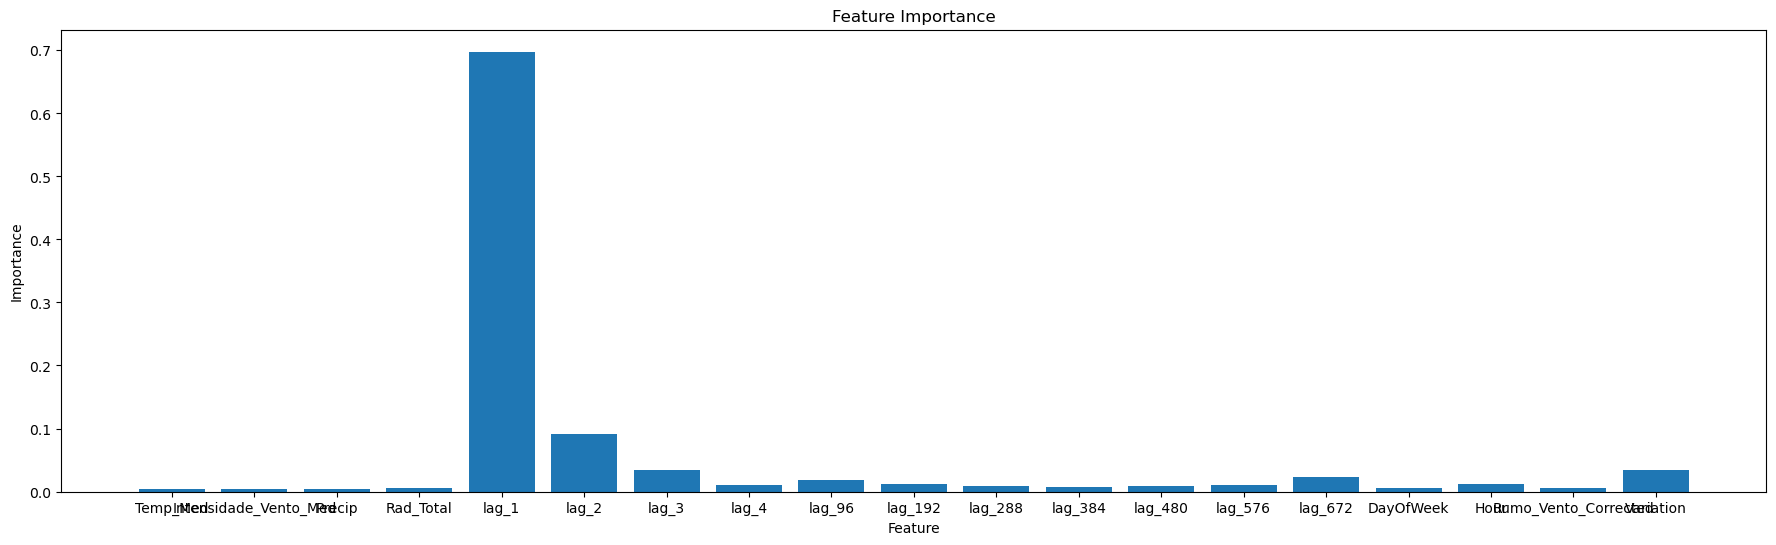

In [57]:
plt.figure(figsize=(22,6))
plt.bar(df.columns[2:-1],model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
#plt.savefig("../../images/loureiro_xgb_feature_importance.png")
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[2:-1],model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

## Hyperparameter Tuning

In [2]:
df_tuning = pd.read_csv("../../data/loureiro_selected.csv")
df_tuning.drop(['Time', 'Location'], axis=1, inplace=True)
df_tuning

,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Energy
0,0.016,0.058,0.038,0.022,0.041,0.023,0.044,0.033,0.032,0.057,0.068,3,12,0.039
1,0.039,0.016,0.058,0.038,0.487,0.034,0.058,0.034,0.029,0.065,0.070,3,12,0.061
2,0.061,0.039,0.016,0.058,0.340,0.037,0.038,0.055,0.047,0.030,0.122,3,12,0.038
3,0.038,0.061,0.039,0.016,0.058,0.046,0.026,0.058,0.022,0.329,0.132,3,12,0.069
4,0.069,0.038,0.061,0.039,0.044,0.024,0.026,0.036,0.020,0.329,0.125,3,13,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413235,0.010,0.009,0.032,0.039,0.015,0.041,0.032,0.009,0.010,0.010,0.023,2,1,0.009
1413236,0.009,0.010,0.009,0.032,0.041,0.037,0.009,0.010,0.009,0.036,0.010,2,1,0.009
1413237,0.009,0.009,0.010,0.009,0.038,0.016,0.010,0.009,0.020,0.039,0.009,2,1,0.040
1413238,0.040,0.009,0.009,0.010,0.022,0.010,0.009,0.009,0.041,0.029,0.010,2,2,0.038


In [3]:
undersample_data = df_tuning.loc[np.linspace(df_tuning.index.min(),df_tuning.index.max(),400000).astype(int)]
#undersample_time = df_index.loc[np.linspace(df_index.index.min(),df_index.index.max(),8784).astype(int)]
undersample_data = undersample_data.reset_index().drop('index',axis=1)
undersample_data

,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour,Energy
0,0.016,0.058,0.038,0.022,0.041,0.023,0.044,0.033,0.032,0.057,0.068,3,12,0.039
1,0.038,0.061,0.039,0.016,0.058,0.046,0.026,0.058,0.022,0.329,0.132,3,12,0.069
2,0.075,0.082,0.063,0.069,0.480,0.061,0.035,0.048,0.057,0.121,0.111,3,13,0.092
3,0.130,0.064,0.092,0.075,0.068,0.444,0.067,0.076,0.048,0.064,0.377,3,14,0.107
4,0.084,0.068,0.068,0.107,0.064,0.062,0.046,0.061,0.039,0.026,0.294,3,15,0.072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,0.036,0.009,0.009,0.010,0.022,0.009,0.009,0.009,0.041,0.027,0.009,1,22,0.038
399996,0.009,0.010,0.034,0.038,0.014,0.041,0.036,0.009,0.009,0.010,0.021,1,23,0.009
399997,0.037,0.009,0.009,0.009,0.023,0.009,0.010,0.010,0.041,0.028,0.009,2,0,0.039
399998,0.010,0.009,0.032,0.039,0.015,0.041,0.032,0.009,0.010,0.010,0.023,2,1,0.009


In [4]:
params_rf = {
    'bootstrap': [True],
    'max_depth': [8, 12, 16],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [500, 700]
}

In [5]:
params_xgb = { 
    'max_depth': [10, 16],
    'learning_rate': [0.001, 0.01, 0.05],
    'n_estimators': [500, 700],
    'colsample_bytree': [0.3, 0.7]
}

In [6]:
train_features = undersample_data.drop('Energy', axis=1)
train_labels = undersample_data['Energy']
test_features = 0
test_labels = 0

In [9]:
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBRegressor(seed=42, tree_method="gpu_hist")

grid_search = GridSearchCV(estimator = xgb_model, param_grid = params_xgb, cv = 3, n_jobs = 8, verbose = 2)

In [8]:
grid_search.fit(train_features, train_labels)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=500; total time=  39.9s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=500; total time=  40.4s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=500; total time=  40.6s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=700; total time=  55.4s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=700; total time=  56.4s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=700; total time=  57.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=500; total time=  42.7s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=500; total time=  43.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=500; total time=  44.4s
[CV] END colsample_by

/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=16, n_estimators=700; total time= 7.2min
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=16, n_estimators=700; total time= 7.6min
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=16, n_estimators=500; total time= 4.9min
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=16, n_estimators=500; total time= 5.2min
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=10, n_estimators=500; total time=  43.6s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=10, n_estimators=500; total time=  44.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=16, n_estimators=700; total time= 8.3min
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=10, n_estimators=500; total time=  43.0s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=10, n_estimators=700; total time=  58.4s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=10, n_estimators=700;

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=8,
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.01, 0.05],
                         'max_depth': [10, 16], 'n_estimators': [500, 700]},
             verbose=2)

In [9]:
grid_search.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 700}

In [10]:
grid_search.best_score_

0.6738982730909172

In [10]:
rf_model = cuRF()

grid_search_rf = GridSearchCV(estimator = rf_model, param_grid = params_rf, cv = 3, n_jobs = 8, verbose = 2)

In [11]:
grid_search_rf.fit(train_features, train_labels)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/minico

[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  21.6s
[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  21.8s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=  21.8s
[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=  21.9s
[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  22.0s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  30.1s
[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  30.2s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=700; total time=  30.4s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=  21.0s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=  21.3s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=  21.3s
[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  29.7s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=  21.5s
[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  30.0s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=700; total time=  30.0s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=700; total time=  29.9s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=700; total time=  29.7s
[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=  21.0s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=  21.2s
[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=700; total time=  29.7s
[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=  21.4s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  29.8s
[CV] END bootstrap=True, max_depth=8, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=700; total time=  29.7s


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [ ]:
grid_search_rf.best_params_

In [ ]:
grid_search_rf.best_score_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = cuRF(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

best_random = grid_search.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
grid_search.best_params_
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))